In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


 **Liberary**

In [ ]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import * 
from keras.models import * 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers
from keras.preprocessing import image 
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.utils import shuffle
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import cv2

**Imprt model**

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/FaceMask/FM_MobileNetV2.h5')


**Grad** **Cam** 

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

**Prediction**

In [ ]:
 
img=image.load_img('/content/gdrive/MyDrive/FaceMask/13.png')
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
preds = model.predict(img) 
i = np.argmax(preds[0])
 

**Display layers**

In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [ ]:
icam = GradCAM(model, i, 'Conv_1_bn')
heatmap = icam.compute_heatmap(img)
heatmap = cv2.resize(heatmap, (244, 244))

image = cv2.imread('/content/gdrive/MyDrive/FaceMask/13.png')
image = cv2.resize(image, (244, 244))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(244, 244) (244, 244, 3)


**Visualization**

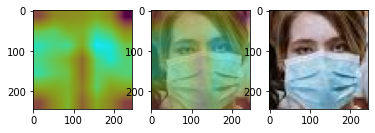

In [ ]:
fig, ax = plt.subplots(1,3)


ax[0].imshow(heatmap)
ax[1].imshow(output)
ax[2].imshow(image )